**Project Task: Week 2**

**Other Regression Techniques:**

1. When store is closed, sales = 0. Can this insight be used for Data Cleaning? Perform this and retrain the model. Any benefits of this step?
2. Use Non-Linear Regressors like Random Forest or other Tree-based Regressors.
    1. Train a single model for all stores, where storeId can be a feature.
    2. Train separate models for each store.
       
       Note: Dimensional Reduction techniques like, PCA and Tree’s Hyperparameter Tuning will be required. Cross-validate to find the best parameters. Infer the performance of both the models. 
       

3. Compare the performance of Linear Model and Non-Linear Model from the previous observations. Which performs better and why?
4. Train a Time-series model on the data taking time as the only feature. This will be a store-level training.
    1. Identify yearly trends and seasonal months

In [1]:
# general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import display
import joblib
pd.set_option('display.max_rows', 500)

# Seeding to ensure consistent accuracy scores for every model iteration
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [2]:
# re-load our original datasets
train = pd.read_csv\
(r"D:\Simplilearn\07 AI Capstone Project\Project 3 Data\train_data.csv")
test = pd.read_csv\
(r"D:\Simplilearn\07 AI Capstone Project\Project 3 Data\test_data.csv")
test_val = pd.read_csv\
(r"D:\Simplilearn\07 AI Capstone Project\Project 3 Data\test_data_hidden.csv")

# removing data where Open == 0
train = train[train.Open==1]
test['Date'] = pd.to_datetime(test['Date'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')

length_train = len(train.index)
length_test = len(test.index)
length_test_val = len(test_val.index)

print('We re-load our original datasets, but now with rows where Open == 0 are removed \n')
print('train shape ↓')
display(train.shape)
print('test shape ↓')
display(test.shape)
print('test_val shape ↓')
display(test_val.shape)

# combining to perform transformations
combi = train.append(test, ignore_index=True)
combi = combi.append(test_val , ignore_index=True)
print('combi shape ↓')
display(combi.shape)

# Creating dummy variables for dates
combi['year'] = pd.to_datetime(combi['Date'],format='%Y-%m-%d').dt.year 
combi['month'] = pd.to_datetime(combi['Date'],format='%Y-%m-%d').dt.month 
combi['day'] = pd.to_datetime(combi['Date'],format='%Y-%m-%d').dt.day
combi['year'] = combi.year.replace({2013 : 0, 2014 : 1 , 2015 : 2 })

# Creating a new timedelta column
combi['date_delta'] = pd.to_datetime(combi['Date'], format='%Y-%m-%d')
combi['date_delta'] = ((combi['date_delta']-combi['date_delta'].min())/np.timedelta64(1,'D')) + 1

# Finally, we also address the StateHoliday variable by converting it from object/string to discrete values
combi['StateHoliday'] = combi.StateHoliday.replace({'0' : 0, 'a' : 1 , 'b' : 2 ,'c' : 3})

# We now have our new set of 'base' data for Open == 1
print('combi ↓')
display(combi)

# Train a single model for all stores, using storeId as a features (now Open no longer needs to be transformed).
combi1 = pd.get_dummies(combi, columns=['Store','DayOfWeek','Promo','StateHoliday','SchoolHoliday','year','month','day'],drop_first=True)
print('combi1 - Single Model for All Stores ↓')
display(combi1.head())

# Train separate model for each store (now Open no longer needs to be transformed).
combi2 = pd.get_dummies(combi, columns=['DayOfWeek', 'Promo','StateHoliday','SchoolHoliday','year','month','day'],drop_first=True)
print('combi2 - Separate Model for Each Store↓')
display(combi2.head())

train3 = combi1.iloc[:length_train].reset_index(drop=True)
test3 = combi1.iloc[length_train:(length_train+length_test)].reset_index(drop=True)
test_val3 = combi1.iloc[(length_train+length_test):].reset_index(drop=True)

train4 = combi2.iloc[:length_train].reset_index(drop=True)
test4 = combi2.iloc[length_train:(length_train+length_test)].reset_index(drop=True)
test_val4 = combi2.iloc[(length_train+length_test):].reset_index(drop=True)

print('train3 shape ↓')
display(train3.shape)
print('test3 shape ↓')
display(test3.shape)
print('test_val3 shape ↓')
display(test_val3.shape)

print('train4 shape ↓')
display(train4.shape)
print('test4 shape ↓')
display(test4.shape)
print('test_val4 shape ↓')
display(test_val4.shape)

We re-load our original datasets, but now with rows where Open == 0 are removed 

train shape ↓


(814204, 9)

test shape ↓


(34565, 8)

test_val shape ↓


(34565, 9)

combi shape ↓


(883334, 9)

combi ↓


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,year,month,day,date_delta
0,1,2,2015-06-30,5735.0,568,1,1,0,0,2,6,30,911.0
1,2,2,2015-06-30,9863.0,877,1,1,0,0,2,6,30,911.0
2,3,2,2015-06-30,13261.0,1072,1,1,0,1,2,6,30,911.0
3,4,2,2015-06-30,13106.0,1488,1,1,0,0,2,6,30,911.0
4,5,2,2015-06-30,6635.0,645,1,1,0,0,2,6,30,911.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
883329,1111,3,2015-07-01,3701.0,351,1,1,0,1,2,7,1,912.0
883330,1112,3,2015-07-01,10620.0,716,1,1,0,1,2,7,1,912.0
883331,1113,3,2015-07-01,8222.0,770,1,1,0,0,2,7,1,912.0
883332,1114,3,2015-07-01,27071.0,3788,1,1,0,0,2,7,1,912.0


combi1 - Single Model for All Stores ↓


,Date,Sales,Customers,Open,date_delta,Store_2,Store_3,Store_4,Store_5,Store_6,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,2015-06-30,5735.0,568,1,911.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2015-06-30,9863.0,877,1,911.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2015-06-30,13261.0,1072,1,911.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2015-06-30,13106.0,1488,1,911.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2015-06-30,6635.0,645,1,911.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


combi2 - Separate Model for Each Store↓


,Store,Date,Sales,Customers,Open,date_delta,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
0,1,2015-06-30,5735.0,568,1,911.0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,2015-06-30,9863.0,877,1,911.0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,2015-06-30,13261.0,1072,1,911.0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4,2015-06-30,13106.0,1488,1,911.0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,2015-06-30,6635.0,645,1,911.0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


train3 shape ↓


(814204, 1173)

test3 shape ↓


(34565, 1173)

test_val3 shape ↓


(34565, 1173)

train4 shape ↓


(814204, 60)

test4 shape ↓


(34565, 60)

test_val4 shape ↓


(34565, 60)

#### Model 3 - Linear Regression - Single Model for All Stores (Open == 1)

In [3]:
%%time 

# # drop Customers as it has a VIF>5, and drop Date as we have already encoded it into dummies
Y_train3 = train3['Sales']
Y_val3 = test_val3['Sales']
X_train3 = train3.drop(['Date','Sales','Open','Customers'],axis=1).values
X_val3 = test_val3.drop(['Date','Sales','Open','Customers'],axis=1).values

# # instantiate
# lr_3 = LinearRegression()

# # fit
# lr_3.fit(X_train3,Y_train3)

# # This regression takes a significant amount of time, so let's save with joblib
# joblib.dump(lr_3, r"D:\Simplilearn\07 AI Capstone Project\Project 3 Data\toCSV\Model3.sav")

Wall time: 2.64 s


In [4]:
# load back and predict
lr_3 = joblib.load(r"D:\Simplilearn\07 AI Capstone Project\Project 3 Data\toCSV\Model3.sav")
Y_pred3 = lr_3.predict(X_val3)

# set predictions as 0 for test_val data, where Open == 0
filter_index = test_val3[test_val3.Open==0].index
for i in filter_index:
    Y_pred3[i] = 0

# evaluate
Model_3_RMSE = np.sqrt(mean_squared_error(Y_pred3,Y_val3))
Model_3_MAPE = (mean_absolute_percentage_error(Y_pred3,Y_val3)*100)

print('Model 3 RMSE %0.3f' %Model_3_RMSE)
print('Model 3 MAPE %0.3f%%' %Model_3_MAPE)

Model 3 RMSE 1229.920
Model 3 MAPE 13.602%


#### Model 4 - Linear Regression - Separate model for each Store (Open == 1)

In [5]:
%%time

Y_pred4 = np.zeros(test_val4.shape[0]) 
Y_val4 = test_val4['Sales'] 

train_bystore = train4.groupby(['Store'])
test_bystore = test_val4.groupby(['Store'])

for i in range(1,1116):
    df1 = train_bystore.get_group(i)
    df2 = test_bystore.get_group(i)
    Y_train4 = df1['Sales']
    X_train4 = df1.drop(['Store','Date','Sales','Customers','Open'],axis=1).values
    X_val4 = df2.drop(['Store','Date','Sales','Customers','Open'],axis=1).values
    model = LinearRegression()
    pred = model.fit(X_train4, Y_train4).predict(X_val4) 
    i = 0
    filter_index = df2[df2['Open']==0].index
    for j in df2.index:
        if (j in filter_index):
            Y_pred4[j] = 0
        else:
            Y_pred4[j] = pred[i]
        i+=1
            
Model_4_RMSE = np.sqrt(mean_squared_error(Y_pred4,Y_val4))
Model_4_MAPE = (mean_absolute_percentage_error(Y_pred4,Y_val4)*100)

print('Model 4 RMSE %0.3f' %Model_4_RMSE)
print('Model 4 MAPE %0.3f%%' %Model_4_MAPE)

Model 4 RMSE 1014.796
Model 4 MAPE 9.561%
Wall time: 6.21 s


In [6]:
print('We can see that with a removal of Open == 0 data, MAPE scores have improved significantly. This is likely due to the elimination of 0 values in Model 3 and Model 4, and we know that MAPE does not handle 0 or negative values well. RMSE scores show less consistent improvement, with Model 3 performing better than Model 1, but Model 4 performs worse than Model 2. However, as we outlined earlier, MAPE scores offers a better means of comparisons between models (when zero or negative values are not present). Consequently we can conclude based on the MAPE scores that model performance has improved when Open == 0 data are removed')

We can see that with a removal of Open == 0 data, MAPE scores have improved significantly. This is likely due to the elimination of 0 values in Model 3 and Model 4, and we know that MAPE does not handle 0 or negative values well. RMSE scores show less consistent improvement, with Model 3 performing better than Model 1, but Model 4 performs worse than Model 2. However, as we outlined earlier, MAPE scores offers a better means of comparisons between models (when zero or negative values are not present). Consequently we can conclude based on the MAPE scores that model performance has improved when Open == 0 data are removed


#### Model 4: Regularization with Ridge Regression

In [7]:
%%time
# Since we saw some improvement in scores following regularization, let's attempt the same on Model 4

Y_pred_ridge4 = np.zeros(test_val4.shape[0]) 
Y_val_ridge4 = test_val4['Sales'] 

train_bystore = train4.groupby(['Store'])
test_bystore = test_val4.groupby(['Store'])

for i in range(1,1116):
    df1 = train_bystore.get_group(i)
    df2 = test_bystore.get_group(i)
    Y_train_ridge4 = df1['Sales']
    X_train_ridge4 = df1.drop(['Store','Date','Sales','Customers','Open'],axis=1).values
    X_val_ridge4 = df2.drop(['Store','Date','Sales','Customers','Open'],axis=1).values
    model = Ridge(alpha=10)
    pred = model.fit(X_train_ridge4, Y_train_ridge4).predict(X_val_ridge4) 
    i = 0
    filter_index = df2[df2['Open']==0].index
    for j in df2.index:
        if (j in filter_index):
            Y_pred_ridge4[j] = 0
        else:
            Y_pred_ridge4[j] = pred[i]
        i+=1
            
Model_ridge4_RMSE = np.sqrt(mean_squared_error(Y_pred_ridge4,Y_val_ridge4))
Model_ridge4_MAPE = (mean_absolute_percentage_error(Y_pred_ridge4,Y_val_ridge4)*100)

print('Model 4 Ridge RMSE %0.3f' %Model_ridge4_RMSE)
print('Model 4 Ridge MAPE %0.3f%%' %Model_ridge4_MAPE)

Model 4 Ridge RMSE 944.354
Model 4 Ridge MAPE 9.017%
Wall time: 4.24 s


In [31]:
# Load our previous modelling results
%store -r Results_All_Models_data
Results_All_Models_data

,Model,RMSE Score,MAPE Score (%)
0,Model_1,"1,427.78",25.54%
1,Model_2,958.59,21.67%
2,Avg_Ensemble (0 & 1),"1,044.47",22.65%
3,Model_1_Ridge,"1,431.52",25.59%
4,Model_2_Ridge,943.77,21.44%
5,Model_2_Bagging,"1,224.31",10.28%
6,Avg_Ensemble_2 (1 & 4),937.91,21.45%
7,Avg_Ensemble_3 (4 & 5),981.58,21.51%


In [32]:
print("With our latest ridge regression on Model 4 (Model_4_Ridge), it has produced our best performing model so far (overall based on both RMSE and MAPE)")

temp3 = pd.DataFrame({
    "Model":          ['Model_3',       'Model_4',       'Model_4_Ridge'],
    "RMSE Score":     [ Model_3_RMSE,    Model_4_RMSE,    Model_ridge4_RMSE],
    "MAPE Score (%)": [ Model_3_MAPE,    Model_4_MAPE,    Model_ridge4_MAPE]})

temp3['RMSE Score'] = temp3['RMSE Score'].map('{:,.2f}'.format)
temp3['MAPE Score (%)'] = temp3['MAPE Score (%)'].map('{:,.2f}%'.format)

Results_All_Models_data = Results_All_Models_data.append(temp3, ignore_index = True)
display(Results_All_Models_data)

With our latest ridge regression on Model 4 (Model_4_Ridge), it has produced our best performing model so far (overall based on both RMSE and MAPE)


,Model,RMSE Score,MAPE Score (%)
0,Model_1,"1,427.78",25.54%
1,Model_2,958.59,21.67%
2,Avg_Ensemble (0 & 1),"1,044.47",22.65%
3,Model_1_Ridge,"1,431.52",25.59%
4,Model_2_Ridge,943.77,21.44%
5,Model_2_Bagging,"1,224.31",10.28%
6,Avg_Ensemble_2 (1 & 4),937.91,21.45%
7,Avg_Ensemble_3 (4 & 5),981.58,21.51%
8,Model_3,"1,229.92",13.60%
9,Model_4,"1,014.80",9.56%


### Non-Linear Regressors

In [10]:
from sklearn.ensemble import RandomForestRegressor
# !pip install xgboost
import xgboost as xgb
from xgboost import XGBRegressor
# from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# no need to scale random forest data: https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package
# can use randomsearchcv instead of gridsesarchcv for faster processing times

In [11]:
# Notes: Running a Random Forest Regression on this dataset with default model values 
# has proven to take an intractable amount of time on my machine. 
# There are different factors that contribute in this issue, to name a few:

# 1. The Number of Attributes (features) in Dataset.
# 2. The Number of Trees (n_estimators).
# 3. The Maximum Depth of the Tree (max_depth).
# 4. The Minimum Number of Samples required to be at a Leaf Node (min_samples_leaf).

#### PCA decomposition on datasets

In [12]:
%%time
# Due to long Random Forest processing times, we should first attempt PCA to reduce the number of features
from sklearn.decomposition import PCA

# pca3 = PCA().fit(X_train3) # takes 30 mins+ to run

# # So we store this variable for use in later segments
# pca3_save = pca3
# %store pca3_save
# del pca3_save

# Load back saved PCA
%store -r pca3_save
pca3 = pca3_save

Wall time: 80 ms


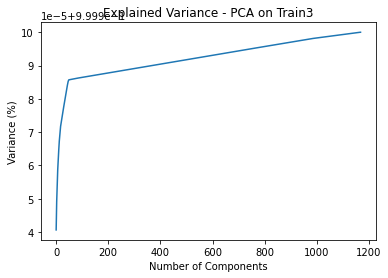

,Component,Explained Variance Ratio
0,PCA Component 1,9.999406e-01
1,PCA Component 2,4.352556e-06
2,PCA Component 3,4.172011e-06
3,PCA Component 4,2.528641e-06
4,PCA Component 5,2.417262e-06
5,PCA Component 6,2.369667e-06
6,PCA Component 7,2.295765e-06
7,PCA Component 8,1.647432e-06
8,PCA Component 9,1.495430e-06
9,PCA Component 10,1.442564e-06


In [13]:
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca3.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance - PCA on Train3')
plt.show()

# dataframe of PCA components and their explained variances
names_pcas = [f"PCA Component {i}" for i in range(1, len(pca3.explained_variance_ratio_), 1)]
scree = pd.DataFrame(list(zip(names_pcas, pca3.explained_variance_ratio_)), columns=["Component", "Explained Variance Ratio"])
scree.head(100)

In [14]:
pca4 = PCA().fit(X_train4)

# So we store this variable for use in later segments
pca4_save = pca4
%store pca4_save
del pca4_save

# Load back saved PCA
%store -r pca4_save
pca4 = pca4_save

Stored 'pca4_save' (PCA)


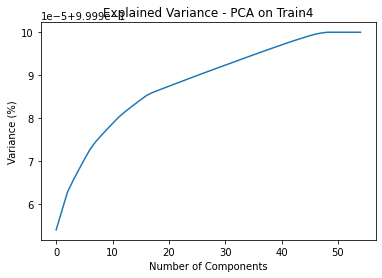

,Component,Explained Variance Ratio
0,PCA Component 1,9.999539e-01
1,PCA Component 2,4.409342e-06
2,PCA Component 3,4.366531e-06
3,PCA Component 4,2.753157e-06
4,PCA Component 5,2.487485e-06
5,PCA Component 6,2.423985e-06
6,PCA Component 7,2.337407e-06
7,PCA Component 8,1.781011e-06
8,PCA Component 9,1.469444e-06
9,PCA Component 10,1.410828e-06


In [15]:
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca4.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance - PCA on Train4')
plt.show()

# dataframe of PCA components and their explained variances
names_pcas2 = [f"PCA Component {i}" for i in range(1, len(pca4.explained_variance_ratio_), 1)]
scree2 = pd.DataFrame(list(zip(names_pcas2, pca4.explained_variance_ratio_)), columns=["Component", "Explained Variance Ratio"])
scree2.head(100)

In [16]:
print('PCA decomposition on our datasets suggest that for X_train3, the first component alone explained 99.994% of the variance (see table), and that explained variance decelerates greatly after 50 components.\n')

print('For X_train4 the results are similar, with the first component explaining 99.995% of variance, followed by slight improvements until component 49. So let us take 50 components for this dataset as well.')

PCA decomposition on our datasets suggest that for X_train3, the first component alone explained 99.994% of the variance (see table), and that explained variance decelerates greatly after 50 components.

For X_train4 the results are similar, with the first component explaining 99.995% of variance, followed by slight improvements until component 49. So let us take 50 components for this dataset as well.


In [17]:
# now let's decompose our data for the following non-linear regressions ahead of time, since running it in
# each instance of a model consumes too much RAM
# we do this for only datasets in Single Model for All Stores (...3) since (...4) is generally performed within the for loop

# Single Model for All Stores
Y_train3 = train3['Sales']
Y_val3 = test_val3['Sales']
X_train3 = train3.drop(['Date','Sales','Open','Customers'],axis=1).values
X_val3 = test_val3.drop(['Date','Sales','Open','Customers'],axis=1).values

# take top 50 PCA components only
pca = PCA(n_components = 50)
X_train3 = pca.fit_transform(X_train3)
X_val3 = pca.fit_transform(X_val3) 

print('Done')

Done


#### Random Forest Regression with PCA

In [18]:
%%time 

# # instantiate with controls on some parameters to reduce calculation time, & set random state to ensure consistent outcomes
# rfr_0 = RandomForestRegressor(n_estimators=500, max_features='sqrt', max_depth=6, random_state= 42, n_jobs=7)
 
# # fit
# rfr_0.fit(X_train3,Y_train3)

# # This regression takes a significant amount of time, so let's save with joblib
# joblib.dump(rfr_0, r"D:\Simplilearn\07 AI Capstone Project\Project 3 Data\toCSV\RFR0.sav")

# load back and predict
rfr_0 = joblib.load(r"D:\Simplilearn\07 AI Capstone Project\Project 3 Data\toCSV\RFR0.sav")
Y_pred_rfr0 = rfr_0.predict(X_val3)

# set predictions as 0 for test_val data, where Open == 0
filter_index = test_val3[test_val3.Open==0].index
for i in filter_index:
    Y_pred_rfr0[i] = 0

# evaluate
Model_rfr0_RMSE = np.sqrt(mean_squared_error(Y_pred_rfr0,Y_val3))
Model_rfr0_MAPE = (mean_absolute_percentage_error(Y_pred_rfr0,Y_val3)*100)

print('Model RFR0 RMSE %0.3f' %Model_rfr0_RMSE)
print('Model RFR0 MAPE %0.3f%%' %Model_rfr0_MAPE)

Model RFR0 RMSE 2932.237
Model RFR0 MAPE 29.120%
Wall time: 757 ms


In [19]:
%%time

# Separate Model for Each Store
# Y_rfr_1 = np.zeros(test_val4.shape[0]) 
# Y_val4 = test_val4['Sales'] 
# pca = PCA(n_components = 31) 
# # due to groupby transformation below, the max number of PCA components that can be set is 31
# # (as described by an error thrown when n_components is attempted at 50)

# train_bystore = train4.groupby(['Store'])
# test_bystore = test_val4.groupby(['Store'])

# for i in range(1,1116):
#     df1 = train_bystore.get_group(i)
#     df2 = test_bystore.get_group(i)
#     Y_train4 = df1['Sales']
#     X_train4 = df1.drop(['Store','Date','Sales','Customers','Open'],axis=1).values
#     X_val4 = df2.drop(['Store','Date','Sales','Customers','Open'],axis=1).values
#     X_train4 = pca.fit_transform(X_train4) # transform with PCA
#     X_val4 = pca.fit_transform(X_val4) # transform with PCA
#     model = RandomForestRegressor(n_estimators=500, max_features='sqrt', max_depth=6, random_state= 42, n_jobs=7)
#     pred = model.fit(X_train4, Y_train4).predict(X_val4) 
#     i = 0
#     filter_index = df2[df2['Open']==0].index
#     for j in df2.index:
#         if (j in filter_index):
#             Y_rfr_1[j] = 0
#         else:
#             Y_rfr_1[j] = pred[i]
#         i+=1

# The above model has already been calculated, with a long wait time
# So we store this variable for use in later segments
# Y_rfr_1_save = Y_rfr_1
# %store Y_rfr_1_save
# del Y_rfr_1_save

# Load back saved PCA
%store -r Y_rfr_1_save
Y_rfr_1 = Y_rfr_1_save

Model_rfr1_RMSE = np.sqrt(mean_squared_error(Y_rfr_1,Y_val4))
Model_rfr1_MAPE = (mean_absolute_percentage_error(Y_rfr_1,Y_val4)*100)

print('Model RFR1 RMSE %0.3f' %Model_rfr1_RMSE)
print('Model RFR1 MAPE %0.3f%%' %Model_rfr1_MAPE)

Model RFR1 RMSE 1610.334
Model RFR1 MAPE 16.360%
Wall time: 29.1 ms


#### Random Forest Regression with PCA + K-Fold CV + RandomizedSearchCV

**The following section has been removed from this assessment due to limitations in computing power**. Initially, the setup was for a 3 K-FoldCV run on RandomizedSearchCV parameter ranges, which totalled 300 iterations:

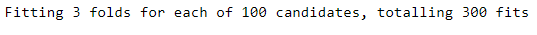

However, following 9 hours of runtime, only 21 samples had been produced, despite running on my GPU. This would therefore have required roughly (9÷21×300) = 5.35 days to complete. Though the code works, in the interest of feasibility, we will forgo this segment.

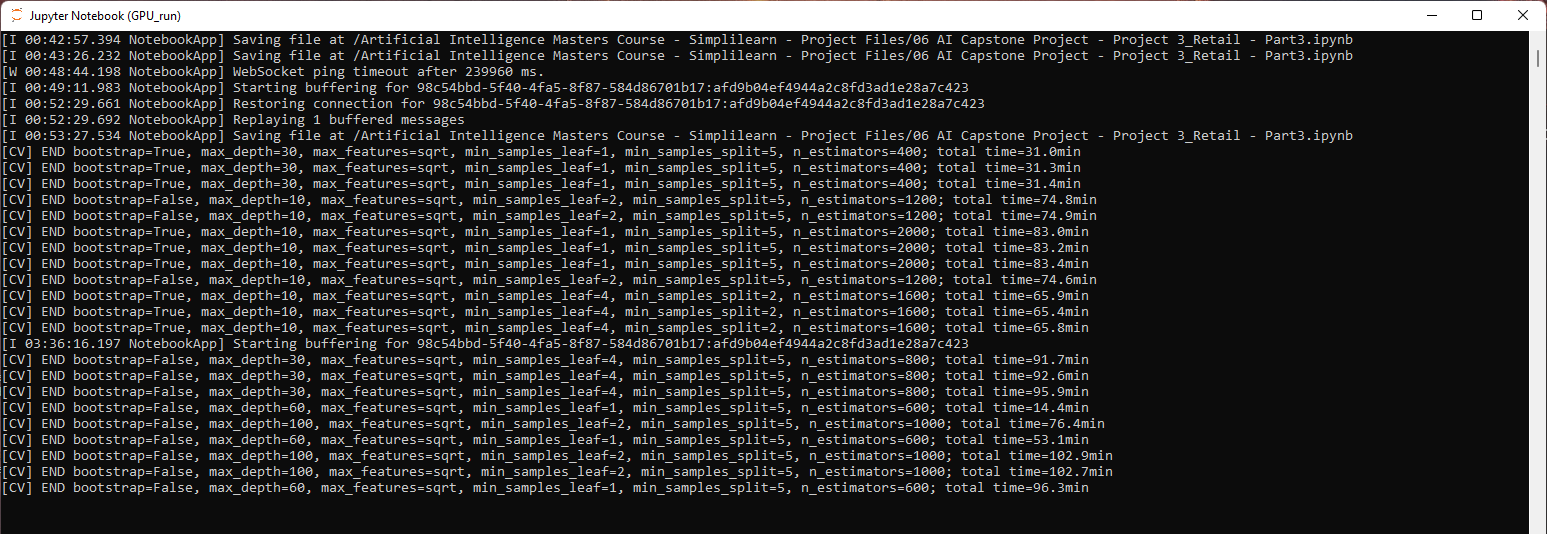

In [20]:
# RUN THIS PROCESS ON GPU
# import tensorflow as tf #already done earlier
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.version.VERSION)
tf.test.is_built_with_cuda()
# tf.test.is_gpu_available()

Num GPUs Available:  1
2.6.0


True

In [21]:
from pprint import pprint

# To implement K-Fold CV, lets take a look at the available Random Forest parameters
rfr_temp = RandomForestRegressor()

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rfr_temp.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [22]:
# Runing Random Forests takes a considerable amount of time, thus we should limit our hyperparameter tuning to the 
# most important parameters only, as listed below. For the same reason of processing time, we have also chosen RandomSearchCV
# instead of GridSearchCV (which would go through each iteration, taking far more time)
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

print('n_estimators = number of trees in the forest')
print('max_features = max number of features considered for splitting a node')
print('max_depth = max number of levels in each decision tree')
print('min_samples_split = min number of data points placed in a node before the node is split')
print('min_samples_leaf = min number of data points allowed in a leaf node')
print('bootstrap = method for sampling data points (with or without replacement')

n_estimators = number of trees in the forest
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node
bootstrap = method for sampling data points (with or without replacement


In [23]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [24]:
# %%time 

# # Now to use the random_grid to search for best hyperparameters
# # First create the base model to tune
# rfr_2_base = RandomForestRegressor()

# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rfr_2_random = RandomizedSearchCV(
#     estimator = rfr_2_base, 
#     param_distributions = random_grid, 
#     n_iter = 100, 
#     cv = 3, 
#     verbose = 2, 
#     random_state = 42, 
#     n_jobs = -1)

# # Fit the random search model
# rfr_2_random.fit(X_train3, Y_train3)

# # Find the best estimators
# rfr_2_random.best_params_

# # save
# rfr_2_random_results = rfr_2_random.best_params_
# %store rfr_2_random_results
# del rfr_2_random_results

# # Load back
# %store -r rfr_2_random_results

# rfr_2_random_results

In [25]:
# # now lets apply the results from our RandomSearch
# rfr_2 = RandomForestRegressor(xxxxxx)
 
# # fit
# rfr_2.fit(X_train3,Y_train3)

# # This regression takes a significant amount of time, so let's save with joblib
# joblib.dump(rfr_2, r"D:\Simplilearn\07 AI Capstone Project\Project 3 Data\toCSV\RFR2.sav")

# # load back and predict
# rfr_2 = joblib.load(r"D:\Simplilearn\07 AI Capstone Project\Project 3 Data\toCSV\RFR2.sav")
# Y_pred_rfr2 = rfr_2.predict(X_val3)

# # set predictions as 0 for test_val data, where Open == 0
# filter_index = test_val3[test_val3.Open==0].index
# for i in filter_index:
#     Y_pred_rfr2[i] = 0

# # evaluate
# Model_rfr2_RMSE = np.sqrt(mean_squared_error(Y_pred_rfr2,Y_val3))
# Model_rfr2_MAPE = (mean_absolute_percentage_error(Y_pred_rfr2,Y_val3)*100)

# print('Model RFR2 RMSE %0.3f' %Model_rfr2_RMSE)
# print('Model RFR2 MAPE %0.3f%%' %Model_rfr2_MAPE)

#### XGBoost with PCA

In [26]:
%%time 

# #instantiate with default parameters
# xgbr_0 = XGBRegressor(verbosity = 0, random_state = 42) 
# # verbosity refers how frequently one wants to see the training progress of each epoch

# # fit
# xgbr_0.fit(X_train3,Y_train3)

# # This regression takes a significant amount of time, so let's save with joblib
# joblib.dump(xgbr_0, r"D:\Simplilearn\07 AI Capstone Project\Project 3 Data\toCSV\XGBR0.sav")

# load back and predict
xgbr_0 = joblib.load(r"D:\Simplilearn\07 AI Capstone Project\Project 3 Data\toCSV\XGBR0.sav")
Y_pred_xgbr0 = xgbr_0.predict(X_val3)

# set predictions as 0 for test_val data, where Open == 0
filter_index = test_val3[test_val3.Open==0].index
for i in filter_index:
    Y_pred_xgbr0[i] = 0

# evaluate
Model_xgbr0_RMSE = np.sqrt(mean_squared_error(Y_pred_xgbr0,Y_val3))
Model_xgbr0_MAPE = (mean_absolute_percentage_error(Y_pred_xgbr0,Y_val3)*100)

print('Model XGBR0 RMSE %0.3f' %Model_xgbr0_RMSE)
print('Model XGBR0 MAPE %0.3f%%' %Model_xgbr0_MAPE)

Model XGBR0 RMSE 3330.535
Model XGBR0 MAPE 32.861%
Wall time: 992 ms


In [27]:
%%time

# Separate Model for Each Store
# Y_pred_xgbr1 = np.zeros(test_val4.shape[0]) 
# Y_val4 = test_val4['Sales'] 
# pca = PCA(n_components = 31) 
# # due to groupby transformation below, the max number of PCA components that can be set is 31
# # (as described by an error thrown when n_components is attempted at 50)

# train_bystore = train4.groupby(['Store'])
# test_bystore = test_val4.groupby(['Store'])

# for i in range(1,1116):
#     df1 = train_bystore.get_group(i)
#     df2 = test_bystore.get_group(i)
#     Y_train4 = df1['Sales']
#     X_train4 = df1.drop(['Store','Date','Sales','Customers','Open'],axis=1).values
#     X_val4 = df2.drop(['Store','Date','Sales','Customers','Open'],axis=1).values
#     X_train4 = pca.fit_transform(X_train4) # transform with PCA
#     X_val4 = pca.fit_transform(X_val4) # transform with PCA
#     model = XGBRegressor(verbosity = 0, random_state = 42) 
#     pred = model.fit(X_train4, Y_train4).predict(X_val4) 
#     i = 0
#     filter_index = df2[df2['Open']==0].index
#     for j in df2.index:
#         if (j in filter_index):
#             Y_pred_xgbr1[j] = 0
#         else:
#             Y_pred_xgbr1[j] = pred[i]
#         i+=1

# # save
# Y_pred_xgbr1_save = Y_pred_xgbr1
# %store Y_pred_xgbr1_save
# del Y_pred_xgbr1_save

# Load back saved Ypred
%store -r Y_pred_xgbr1_save
Y_pred_xgbr1 = Y_pred_xgbr1_save

Model_xgbr1_RMSE = np.sqrt(mean_squared_error(Y_pred_xgbr1,Y_val4))
Model_xgbr1_MAPE = (mean_absolute_percentage_error(Y_pred_xgbr1,Y_val4)*100)

print('Model XGBR1 RMSE %0.3f' %Model_xgbr1_RMSE)
print('Model XGBR1 MAPE %0.3f%%' %Model_xgbr1_MAPE)

Model XGBR1 RMSE 1872.061
Model XGBR1 MAPE 18.539%
Wall time: 19.8 ms


#### XGBoost with PCA + Bayesian Optimization for Hyperparameter Tuning

In [28]:
%%time

# # #Converting the dataframe into XGBoost’s Dmatrix object
# dtrain = xgb.DMatrix(X_train3, label = Y_train3)

# # #Bayesian Optimization function for xgboost
# # #specify the parameters you want to tune as keyword arguments
# def bo_tune_xgb(max_depth, gamma, n_estimators ,learning_rate):
#     params = {'max_depth': int(max_depth),
#               'gamma': gamma,
#               'n_estimators': int(n_estimators),
#               'learning_rate':learning_rate,
#               'random_state': 42,
#               'verbosity': 0, 
#               'subsample': 0.8,
#               'eta': 0.1,
#               'eval_metric': 'rmse'}
#     #Cross validating with the specified parameters in 5 folds and 70 iterations
#     cv_result = xgb.cv(params, dtrain, num_boost_round = 70, nfold = 5)
#     #Return the negative RMSE
#     return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

# # Invoking the Bayesian Optimizer with the specified range of parameters to tune
# xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
#                                              'gamma': (0, 1),
#                                              'learning_rate':(0, 1),
#                                              'n_estimators':(100, 400)
#                                             })

# # performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an acquisition function of expected improvement
# xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

# #Extracting the best parameters
# params = xgb_bo.max['params']
# print(params)

# # Converting the max_depth and n_estimator values from float to int, and rounding it
# # This is required to allow it for use in fit as values in param have many decimal places
# # the function proper_round is called since it appears round() has to be called separately instead of directly within a single line
# # see: https://stackoverflow.com/questions/31818050/round-number-to-nearest-integer
# def proper_round(num, dec=0):
#     num = str(num)[:str(num).index('.')+dec+2]
#     if num[-1]>='5':
#         return float(num[:-2-(not dec)]+str(int(num[-2-(not dec)])+1))
#     return float(num[:-1])

# params['max_depth'] = int(proper_round(params['max_depth'],0))
# params['n_estimators'] = int(proper_round(params['n_estimators'],0))

# # save
# params_save = params
# %store params_save
# del params_save

# # Load back saved parameters of our bayesian-optimization
# %store -r params_save
# params = params_save

# #Initialize an XGBRegressor with the tuned parameters, and fit the training data
# xgbr_2 = XGBRegressor(**params).fit(X_train3, Y_train3)

# #predict
# Y_pred_xgbr2 = xgbr_2.predict(X_val3)

# # save
# Y_pred_xgbr2_save = Y_pred_xgbr2
# %store Y_pred_xgbr2_save
# del Y_pred_xgbr2_save

# Load back saved Ypred
%store -r Y_pred_xgbr2_save
Y_pred_xgbr2 = Y_pred_xgbr2_save

Model_xgbr2_RMSE = np.sqrt(mean_squared_error(Y_pred_xgbr2,Y_val4))
Model_xgbr2_MAPE = (mean_absolute_percentage_error(Y_pred_xgbr2,Y_val4)*100)

print('Model XGBR2 RMSE %0.3f' %Model_xgbr2_RMSE)
print('Model XGBR2 MAPE %0.3f%%' %Model_xgbr2_MAPE)

Model XGBR2 RMSE 6244.636
Model XGBR2 MAPE 47.812%
Wall time: 2.96 ms


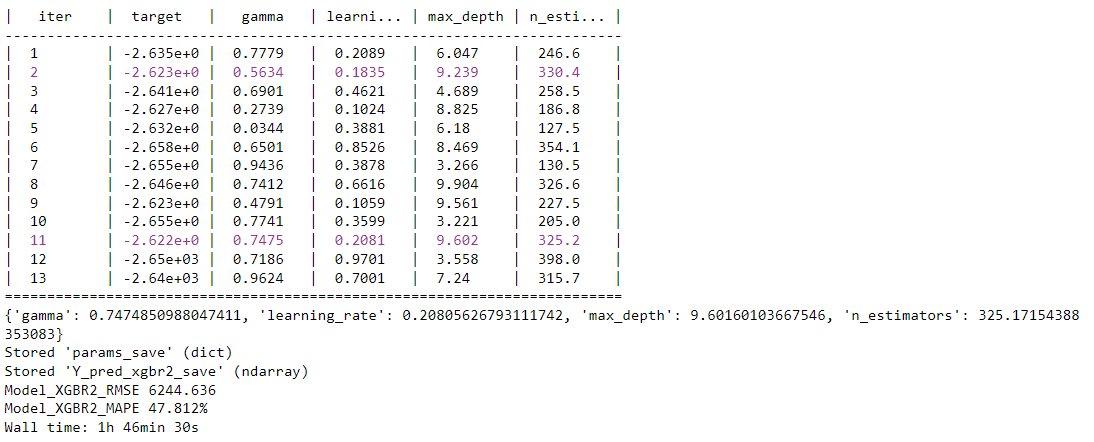
This is the orginal output of the above model. Due to long runtimes, we save the predict output instead to report on RMSE/MAPE

In [29]:
# Separate Model for Each Store

# Unfortunately, running the bayesian optimization for all 1115 XGBRegressions for this section would likely
# prove to take days of calculation time, similar to that for our Random Forest (Separate Model for Each Store) models. 
# Furthermore, our initial results of Model_XGBR2 suggest that XGBRegressions are the worst performing model so far, 
# so my best guess is that it is unlikely to be one of the best either way.

# print('Model XGBR3 RMSE %0.3f' %Model_xgbr3_RMSE)
# print('Model XGBR3 MAPE %0.3f%%' %Model_xgbr3_MAPE)

In [33]:
print("Following our latest round of Non-Linear Regressions, Model 4 (Model_4_Ridge) continues to be the best performing model so far (overall based on both RMSE and MAPE)\n")
print("None of the non-linear regressions seem to have outperformed linear models, which is actually evident from our pairplots during our EDA step. The pairplots generally indicate linear relationships for Sales")

temp4 = pd.DataFrame({
    "Model":          ['Model RFR0',       'Model RFR1',       'Model RFR2',   'Model XGBR0' ,       'Model XGBR1' ,       'Model XGBR2',       'Model XGBR3'],
    "RMSE Score":     [ Model_rfr0_RMSE,    Model_rfr1_RMSE,    0,              Model_xgbr0_RMSE ,    Model_xgbr1_RMSE ,    Model_xgbr2_RMSE,    0],
    "MAPE Score (%)": [ Model_rfr0_MAPE,    Model_rfr1_MAPE,    0,              Model_xgbr0_MAPE ,    Model_xgbr1_MAPE ,    Model_xgbr2_MAPE,    0]})

temp4['RMSE Score'] = temp4['RMSE Score'].map('{:,.2f}'.format)
temp4['MAPE Score (%)'] = temp4['MAPE Score (%)'].map('{:,.2f}%'.format)

Results_All_Models_data = Results_All_Models_data.append(temp4, ignore_index = True)
display(Results_All_Models_data)

print("Note: Model RFR2 and XGBR3 have 0 values as they could not be processed within a normal amount of time due to limitations in hardware/insufficient time. In any case, they would not have likely had better RMSE and MAPE scores than the linear models")

Following our latest round of Non-Linear Regressions, Model 4 (Model_4_Ridge) continues to be the best performing model so far (overall based on both RMSE and MAPE)

None of the non-linear regressions seem to have outperformed linear models, which is actually evident from our pairplots during our EDA step. The pairplots generally indicate linear relationships for Sales


,Model,RMSE Score,MAPE Score (%)
0,Model_1,"1,427.78",25.54%
1,Model_2,958.59,21.67%
2,Avg_Ensemble (0 & 1),"1,044.47",22.65%
3,Model_1_Ridge,"1,431.52",25.59%
4,Model_2_Ridge,943.77,21.44%
5,Model_2_Bagging,"1,224.31",10.28%
6,Avg_Ensemble_2 (1 & 4),937.91,21.45%
7,Avg_Ensemble_3 (4 & 5),981.58,21.51%
8,Model_3,"1,229.92",13.60%
9,Model_4,"1,014.80",9.56%


Note: Model RFR2 and XGBR3 have 0 values as they could not be processed within a normal amount of time due to limitations in hardware/insufficient time. In any case, they would not have likely had better RMSE and MAPE scores than the linear models


In [35]:
# Store this variable for use in later segments
%store Results_All_Models_data

Stored 'Results_All_Models_data' (DataFrame)
